# Proyek Machine Learning - Sistem Rekomendasi Film

**Nama:** Muhammad Mahathir

**Email:** mhmmdmhthr@gmail.com

**ID Dicoding:** MC322D5Y1764

## 1. Import Library yang Dibutuhkan

In [101]:
# Library dasar untuk analisis dan manipulasi data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import tensorflow as tf
from tensorflow import keras

# Untuk menampilkan progress bar
from tqdm import tqdm

# Mengabaikan warning yang tidak perlu
import warnings
warnings.filterwarnings('ignore')

# Mengatur gaya visualisasi
plt.style.use('ggplot')
sns.set(style='whitegrid')

## 2. Data Understanding

Dataset MovieLens Small Latest adalah dataset yang berisi rating film dari pengguna MovieLens. Dataset ini dikeluarkan oleh GroupLens Research dan merupakan versi kecil dari dataset MovieLens yang lebih besar.

Dataset ini terdiri dari 100.836 rating dan 3.683 tag yang diberikan pada 9.742 film oleh 610 pengguna. Data ini dibuat antara 29 Maret 1996 dan 24 September 2018. Dataset ini didesain untuk tujuan pendidikan dan penelitian dalam bidang sistem rekomendasi.

### Sumber Data:
Dataset ini dapat diunduh dari [GroupLens](https://grouplens.org/datasets/movielens/latest/) atau melalui [Kaggle](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset).

Dataset ini terdiri dari beberapa file:
- **ratings.csv**: Berisi rating film dari pengguna (userId, movieId, rating, timestamp)
- **movies.csv**: Berisi informasi tentang film (movieId, title, genres)
- **tags.csv**: Berisi tag yang diberikan pengguna pada film (userId, movieId, tag, timestamp)
- **links.csv**: Berisi tautan ke database film lain (movieId, imdbId, tmdbId)

Mari kita mulai dengan mengimpor dataset dan memeriksa struktur datanya.

In [102]:
# Membaca file dataset
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

### 2.1 Memeriksa data ratings

In [103]:
# Melihat lima baris pertama dari dataset ratings
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [104]:
# Melihat ukuran dataset ratings
print(f"Jumlah baris: {ratings.shape[0]}")
print(f"Jumlah kolom: {ratings.shape[1]}")

Jumlah baris: 100836
Jumlah kolom: 4


In [105]:
# Melihat informasi dataset ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [106]:
# Melihat statistik deskriptif dataset ratings
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**Penjelasan Dataset Ratings**:

Dataset ratings terdiri dari 100.836 baris dan 4 kolom dengan karakteristik sebagai berikut:
- **userId**: ID unik untuk setiap pengguna (1 sampai 610)
- **movieId**: ID unik untuk setiap film
- **rating**: Rating yang diberikan oleh pengguna (skala 0.5 sampai 5.0 dengan interval 0.5)
- **timestamp**: Waktu rating diberikan (dalam format Unix timestamp)

Rata-rata rating yang diberikan adalah sekitar 3.5, dengan rating minimum 0.5 dan maksimum 5.0.

### 2.2 Memeriksa data movies

In [107]:
# Melihat lima baris pertama dari dataset movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [108]:
# Melihat ukuran dataset movies
print(f"Jumlah baris (film): {movies.shape[0]}")
print(f"Jumlah kolom: {movies.shape[1]}")

Jumlah baris (film): 9742
Jumlah kolom: 3


In [109]:
# Melihat informasi dataset movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Penjelasan Dataset Movies**:

Dataset movies terdiri dari 9.742 baris dan 3 kolom dengan karakteristik sebagai berikut:
- **movieId**: ID unik untuk setiap film
- **title**: Judul film yang biasanya disertai dengan tahun rilis dalam tanda kurung
- **genres**: Genre film yang dipisahkan dengan karakter '|', misalnya "Adventure|Animation|Children|Comedy|Fantasy"

### 2.3 Memeriksa data tags

In [110]:
# Melihat lima baris pertama dari dataset tags
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [111]:
# Melihat ukuran dataset tags
print(f"Jumlah baris: {tags.shape[0]}")
print(f"Jumlah kolom: {tags.shape[1]}")

Jumlah baris: 3683
Jumlah kolom: 4


In [112]:
# Melihat informasi dataset tags
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


**Penjelasan Dataset Tags**:

Dataset tags terdiri dari 3.683 baris dan 4 kolom dengan karakteristik sebagai berikut:
- **userId**: ID unik untuk setiap pengguna
- **movieId**: ID unik untuk setiap film
- **tag**: Tag yang diberikan oleh pengguna pada film tertentu
- **timestamp**: Waktu tag diberikan (dalam format Unix timestamp)

### 2.4 Memeriksa data links

In [113]:
# Melihat lima baris pertama dari dataset links
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [114]:
# Melihat ukuran dataset links
print(f"Jumlah baris: {links.shape[0]}")
print(f"Jumlah kolom: {links.shape[1]}")

Jumlah baris: 9742
Jumlah kolom: 3


In [115]:
# Melihat informasi dataset links
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


**Penjelasan Dataset Links**:

Dataset links terdiri dari 9.742 baris dan 3 kolom dengan karakteristik sebagai berikut:
- **movieId**: ID unik untuk setiap film (sama dengan movieId di dataset movies)
- **imdbId**: ID film di database IMDb
- **tmdbId**: ID film di database The Movie Database (TMDb)

Dataset ini berguna untuk menghubungkan film di dataset MovieLens dengan data eksternal dari IMDb dan TMDb.

### 2.5 Memeriksa nilai yang hilang (missing values)

In [116]:
# Missing Values di dataset ratings
print("Missing values di dataset ratings:")
print(ratings.isnull().sum())

Missing values di dataset ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [117]:
# Missing Values di dataset movies
print("Missing values di dataset movies:")
print(movies.isnull().sum())

Missing values di dataset movies:
movieId    0
title      0
genres     0
dtype: int64


In [118]:
# Missing Values di dataset tags
print("Missing values di dataset tags:")
print(tags.isnull().sum())

Missing values di dataset tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [119]:
# Missing Values di dataset links
print("Missing values di dataset links:")
print(links.isnull().sum())

Missing values di dataset links:
movieId    0
imdbId     0
tmdbId     8
dtype: int64


### 2.6 Memeriksa duplikat dalam dataset

In [120]:
# Jumlah duplikat di dataset ratings
print(f"Jumlah duplikat di dataset ratings: {ratings.duplicated().sum()}")

Jumlah duplikat di dataset ratings: 0


In [121]:
# Jumlah duplikat di dataset movies
print(f"Jumlah duplikat di dataset movies: {movies.duplicated().sum()}")

Jumlah duplikat di dataset movies: 0


In [122]:
# Jumlah duplikat di dataset tags
print(f"Jumlah duplikat di dataset tags: {tags.duplicated().sum()}")

Jumlah duplikat di dataset tags: 0


In [123]:
# Jumlah duplikat di dataset links
print(f"Jumlah duplikat di dataset links: {links.duplicated().sum()}")

Jumlah duplikat di dataset links: 0


**Insight Duplikat Data**:

- Tidak ada duplikat di dataset ratings, movies, dan links
- Tidak ada duplikat di dataset tags

Hal ini menunjukkan bahwa dataset ini sudah cukup bersih dan tidak perlu dilakukan penanganan duplikat.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Analisis Dataset Ratings

In [124]:
# Menampilkan statistik dasar dari rating
ratings_stats = pd.DataFrame({
    'Statistik': ['Min Rating', 'Max Rating', 'Rating Rata-rata', 'Median Rating', 'Standar Deviasi Rating'],
    'Nilai': [ratings['rating'].min(), ratings['rating'].max(),
              ratings['rating'].mean(), ratings['rating'].median(),
              ratings['rating'].std()]
})

ratings_stats

,Statistik,Nilai
0,Min Rating,0.500000
1,Max Rating,5.000000
2,Rating Rata-rata,3.501557
3,Median Rating,3.500000
4,Standar Deviasi Rating,1.042529


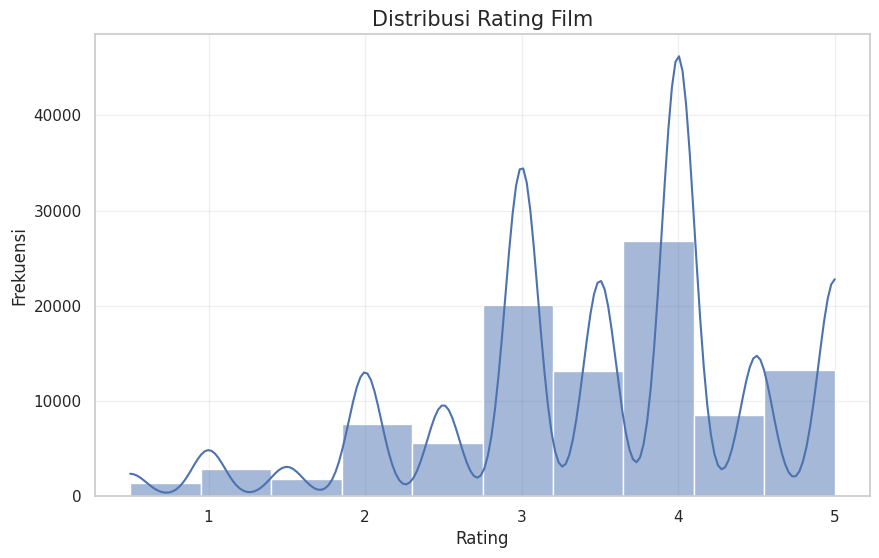

In [125]:
# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='rating', bins=10, kde=True)
plt.title('Distribusi Rating Film', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Insight Distribusi Rating**:

- Rating bervariasi dari 0.5 hingga 5.0 dengan interval 0.5
- Rata-rata rating adalah sekitar 3.5, yang menunjukkan bahwa pengguna cenderung memberikan rating positif
- Rating 4.0 adalah yang paling umum diberikan, diikuti oleh rating 3.0 dan 5.0
- Distribusi rating sedikit miring ke kanan (positively skewed), yang menunjukkan kecenderungan pengguna memberikan rating yang lebih tinggi

### 3.2 Analisis Dataset Movies

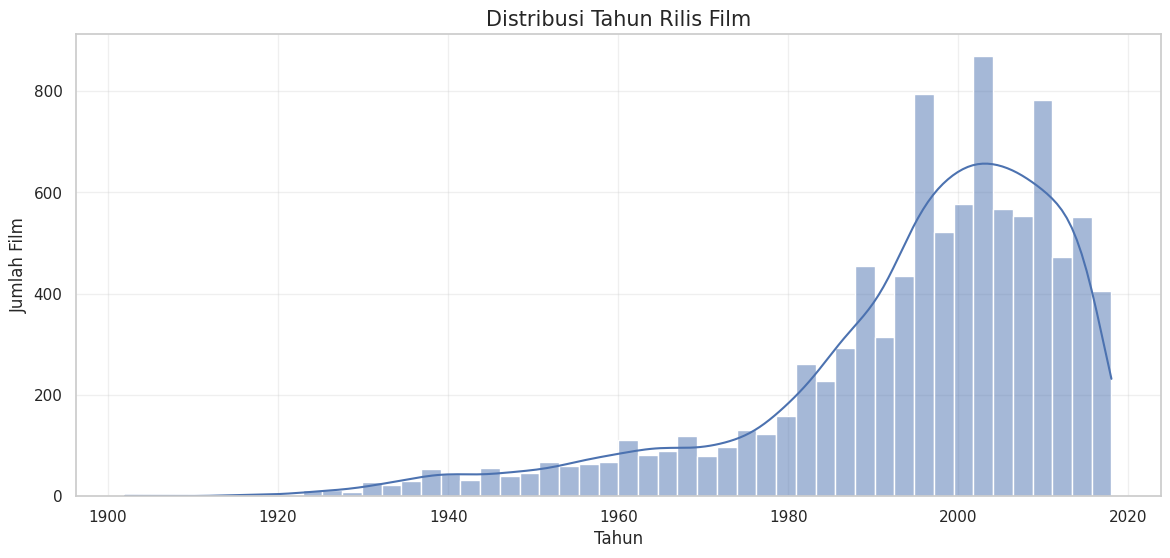

In [126]:
# Ekstrak tahun dari judul film
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype('float')

# Visualisasi distribusi tahun film
plt.figure(figsize=(14, 6))
sns.histplot(data=movies, x='year', bins=50, kde=True)
plt.title('Distribusi Tahun Rilis Film', fontsize=15)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

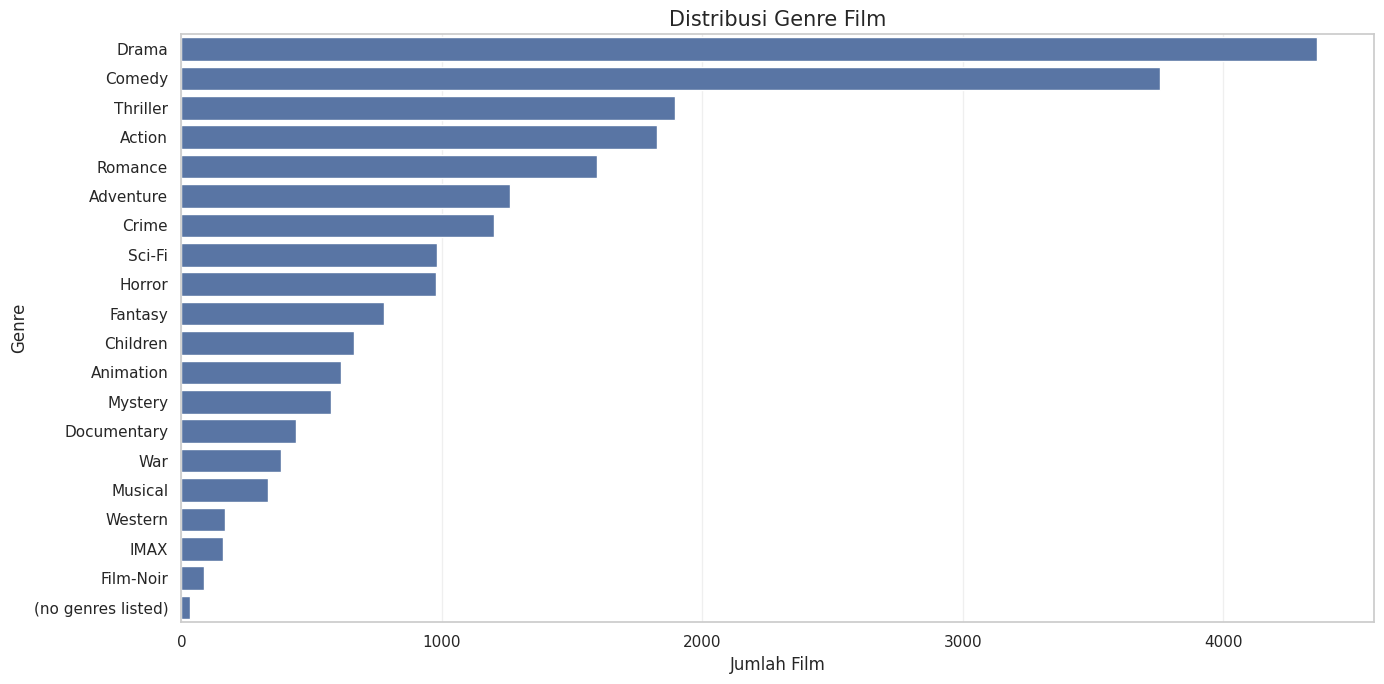

In [127]:
# Memisahkan genre menjadi list
movies['genres_list'] = movies['genres'].str.split('|')

# Menghitung jumlah genre untuk setiap film
genres_count = {}
for genres in movies['genres_list']:
    for genre in genres:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

# Mengurutkan genre berdasarkan jumlah
genres_df = pd.DataFrame({'Genre': list(genres_count.keys()), 'Count': list(genres_count.values())})
genres_df = genres_df.sort_values('Count', ascending=False)

# Visualisasi distribusi genre
plt.figure(figsize=(14, 7))
sns.barplot(x='Count', y='Genre', data=genres_df)
plt.title('Distribusi Genre Film', fontsize=15)
plt.xlabel('Jumlah Film', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 3.3 Analisis Dataset Tags

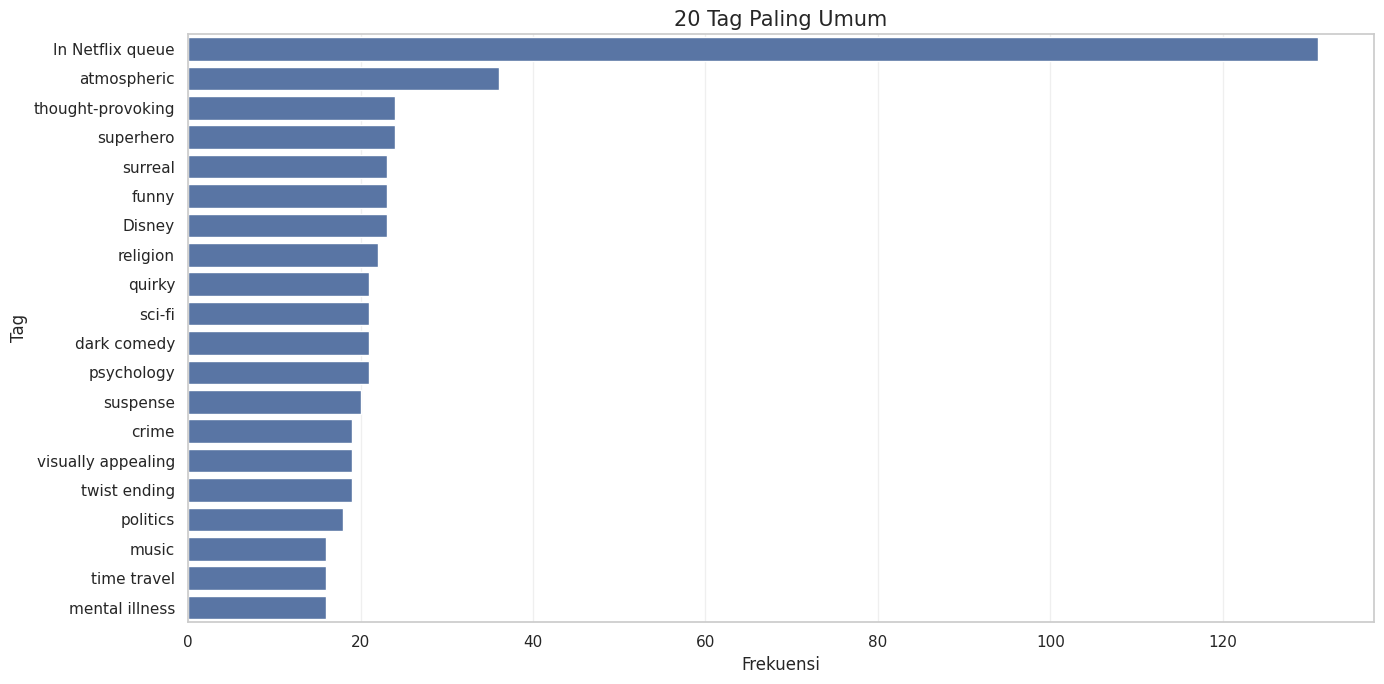

In [128]:
# Melihat tag yang paling umum
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title('20 Tag Paling Umum', fontsize=15)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 3.4 Analisis User

In [129]:
# Melihat jumlah rating yang diberikan oleh setiap user
user_ratings_count = ratings['userId'].value_counts()

# Menampilkan statistik jumlah rating per user
user_ratings_stats = pd.DataFrame({
    'Statistik': ['Min', 'Max', 'Rata-rata', 'Median'],
    'Nilai': [user_ratings_count.min(), user_ratings_count.max(),
              user_ratings_count.mean(), user_ratings_count.median()]
})

user_ratings_stats

,Statistik,Nilai
0,Min,20.000000
1,Max,2698.000000
2,Rata-rata,165.304918
3,Median,70.500000


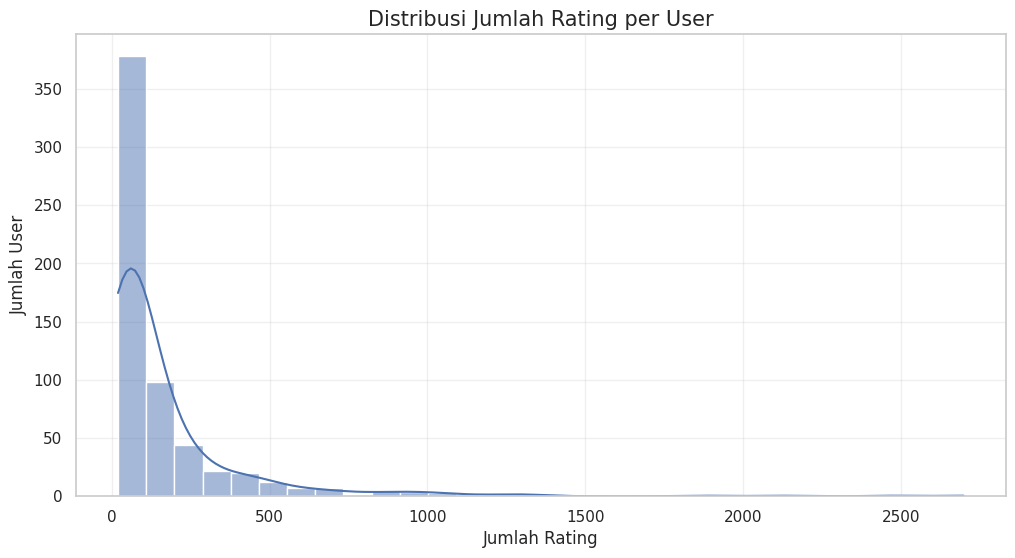

In [130]:
# Visualisasi distribusi jumlah rating per user
plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count, bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per User', fontsize=15)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Jumlah User', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### 3.5 Analisis Film

In [131]:
# Melihat jumlah rating yang diterima oleh setiap film
movie_ratings_count = ratings['movieId'].value_counts()

# Menampilkan statistik jumlah rating per film
movie_ratings_stats = pd.DataFrame({
    'Statistik': ['Min', 'Max', 'Rata-rata', 'Median'],
    'Nilai': [movie_ratings_count.min(), movie_ratings_count.max(),
              movie_ratings_count.mean(), movie_ratings_count.median()]
})

movie_ratings_stats

,Statistik,Nilai
0,Min,1.000000
1,Max,329.000000
2,Rata-rata,10.369807
3,Median,3.000000


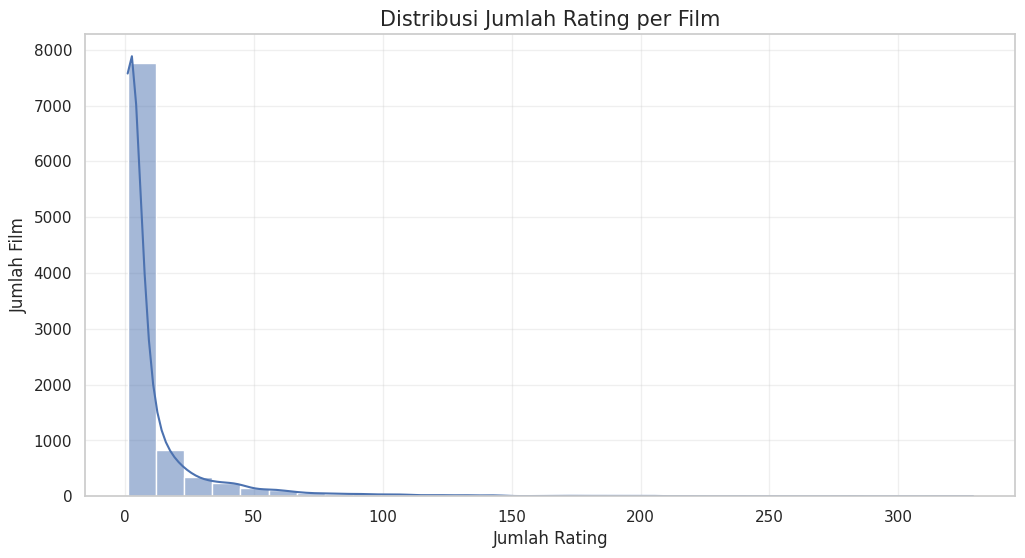

In [132]:
# Visualisasi distribusi jumlah rating per film
plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_count, bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per Film', fontsize=15)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

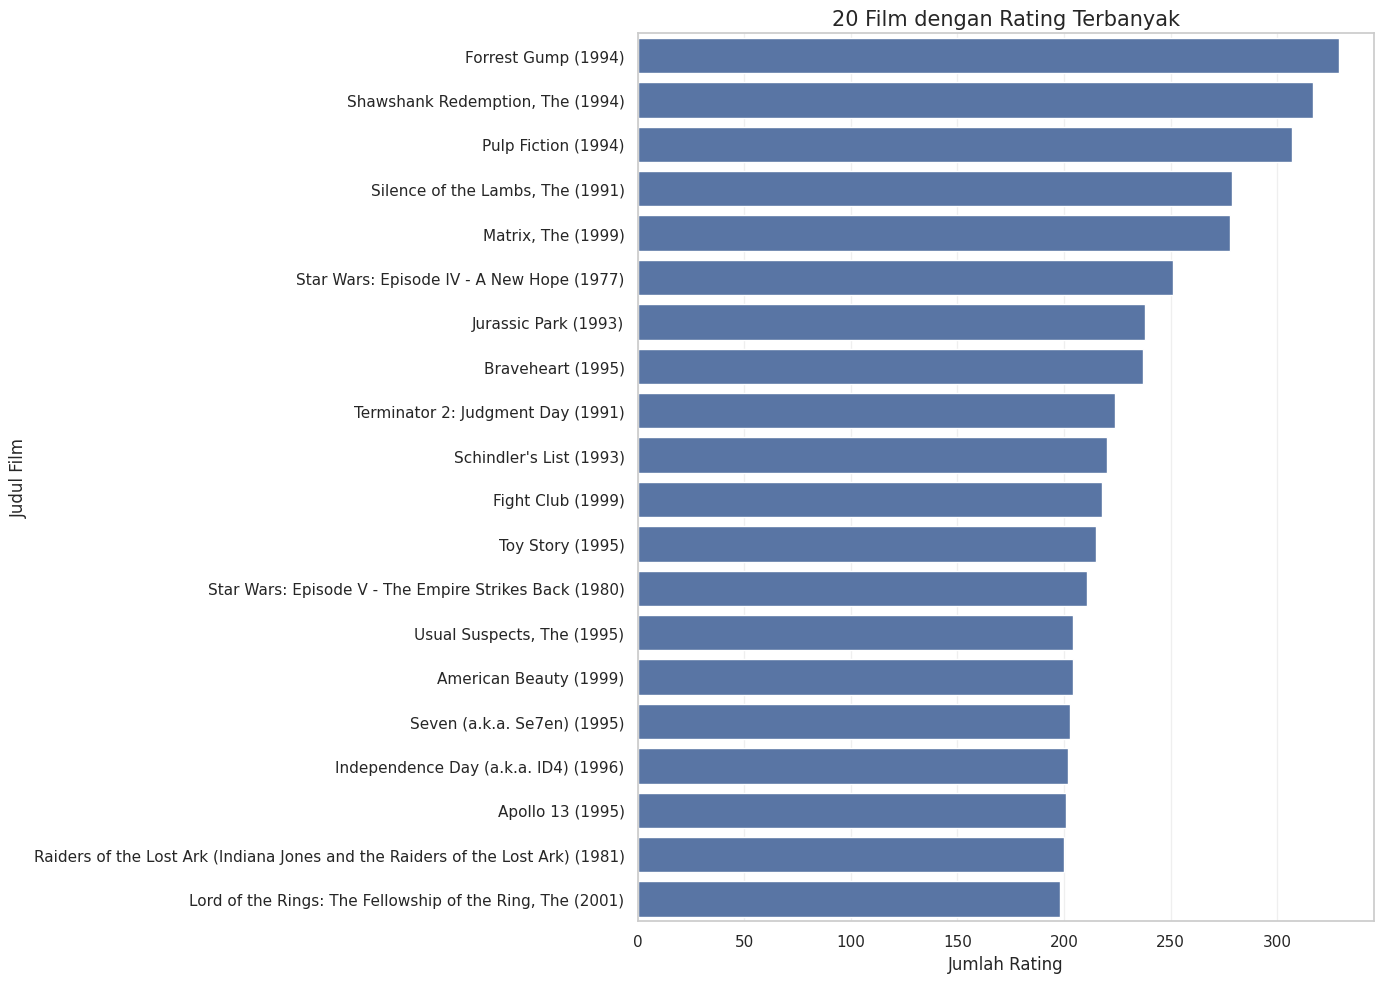

In [133]:
# Film dengan rating terbanyak
top_movies = pd.DataFrame({'movieId': movie_ratings_count.index, 'count': movie_ratings_count.values})
top_movies = top_movies.merge(movies, on='movieId')
top_movies = top_movies.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x='count', y='title', data=top_movies)
plt.title('20 Film dengan Rating Terbanyak', fontsize=15)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 3.6 Analisis Rating Rata-rata per Film

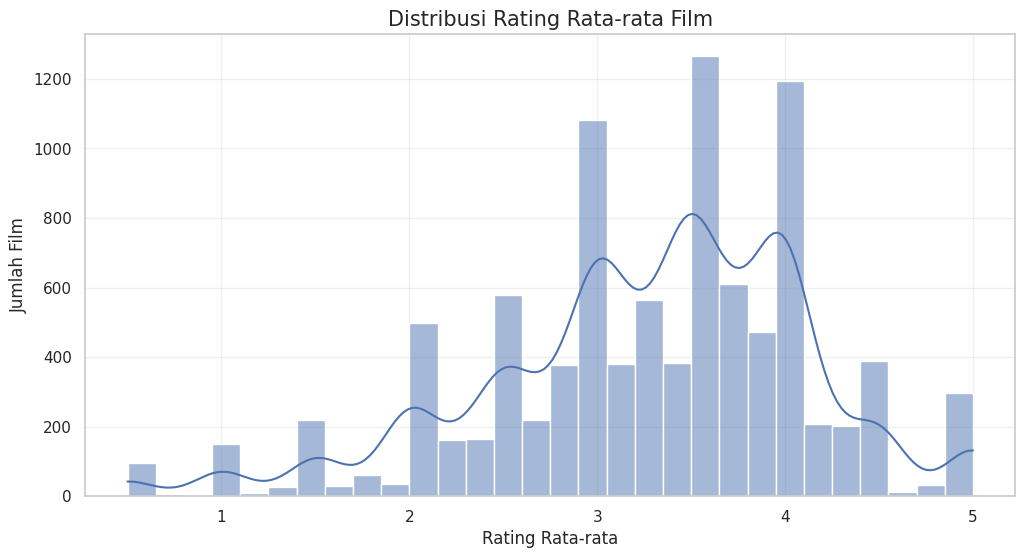

In [134]:
# Menghitung rating rata-rata untuk setiap film
movie_avg_rating = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.columns = ['movieId', 'avg_rating']

# Menggabungkan dengan data film
movie_avg_rating = movie_avg_rating.merge(movies, on='movieId')

# Visualisasi distribusi rating rata-rata
plt.figure(figsize=(12, 6))
sns.histplot(movie_avg_rating['avg_rating'], bins=30, kde=True)
plt.title('Distribusi Rating Rata-rata Film', fontsize=15)
plt.xlabel('Rating Rata-rata', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [135]:
# Menampilkan film dengan rating rata-rata tertinggi (minimal 50 rating)
movie_ratings_count_df = pd.DataFrame(movie_ratings_count).reset_index()
movie_ratings_count_df.columns = ['movieId', 'count']

movie_rating_analysis = movie_avg_rating.merge(movie_ratings_count_df, on='movieId')
popular_movies = movie_rating_analysis[movie_rating_analysis['count'] >= 50].sort_values('avg_rating', ascending=False)

# Top 10 film dengan rating tertinggi (minimal 50 rating)
print("Top 10 Film dengan Rating Tertinggi (minimal 50 rating):")
popular_movies[['title', 'genres', 'avg_rating', 'count']].head(10)

Top 10 Film dengan Rating Tertinggi (minimal 50 rating):


,title,genres,avg_rating,count
277,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317
659,"Godfather, The (1972)",Crime|Drama,4.289062,192
2224,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936,218
974,Cool Hand Luke (1967),Drama,4.271930,57
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.268041,97
686,Rear Window (1954),Mystery|Thriller,4.261905,84
921,"Godfather: Part II, The (1974)",Crime|Drama,4.259690,129
6298,"Departed, The (2006)",Crime|Drama|Thriller,4.252336,107
913,Goodfellas (1990),Crime|Drama,4.250000,126
694,Casablanca (1942),Drama|Romance,4.240000,100


## 4. Data Preprocessing

### 4.1 Mengkonversi timestamp menjadi format datetime

In [136]:
# Mengkonversi timestamp menjadi format datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Menampilkan sample data setelah konversi timestamp
print("Dataset ratings setelah konversi timestamp:")
ratings.head()

Dataset ratings setelah konversi timestamp:


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


**Penjelasan Konversi Timestamp**:

Konversi timestamp dari format Unix timestamp (detik sejak 1 Januari 1970) menjadi format datetime standard Python memudahkan kita untuk melakukan analisis berdasarkan waktu. Dengan format datetime, kita bisa dengan mudah mengekstrak informasi seperti tahun, bulan, atau hari saat rating diberikan.

### 4.2 Menggabungkan dataset ratings dan movies

In [137]:
# Menggabungkan dataset ratings dan movies berdasarkan movieId
ratings_movies = pd.merge(ratings, movies, on='movieId')
print("Dataset gabungan ratings dan movies:")
ratings_movies.head()

Dataset gabungan ratings dan movies:


,userId,movieId,rating,timestamp,title,genres,year,genres_list
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,1995.0,"[Comedy, Romance]"
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,1995.0,"[Action, Crime, Thriller]"
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0,"[Mystery, Thriller]"
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0,"[Crime, Mystery, Thriller]"


In [138]:
# Melihat ukuran dataset gabungan
print(f"Ukuran dataset gabungan: {ratings_movies.shape}")

Ukuran dataset gabungan: (100836, 8)


**Penjelasan Penggabungan Dataset**:

Untuk mempermudah analisis dan pemodelan, kita menggabungkan dataset ratings dan movies berdasarkan kolom movieId. Hasil penggabungan ini adalah dataset dengan 100.836 baris (sama dengan jumlah baris di dataset ratings) dan 7 kolom yang berisi informasi rating beserta detail film yang diberi rating.

## 5. Data Preparation untuk Content-Based Filtering

In [139]:
# Persiapan data untuk content-based filtering
# Fokus pada fitur 'genres' untuk membuat rekomendasi

# Membuat TF-IDF matrix dari genre film
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].fillna('')  # Pastikan tidak ada nilai NaN
tfidf_matrix = tfidf.fit_transform(movies['genres'].str.replace('|', ' '))

print(f"Ukuran TF-IDF Matrix: {tfidf_matrix.shape}")
print(f"Feature names: {tfidf.get_feature_names_out()[:20]}")  # Menampilkan 20 feature names pertama

Ukuran TF-IDF Matrix: (9742, 23)
Feature names: ['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'genres' 'horror' 'imax'
 'listed' 'musical' 'mystery' 'noir' 'romance' 'sci']


In [140]:
# Menghitung cosine similarity antara film berdasarkan genre
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Ukuran Cosine Similarity Matrix: {cosine_sim.shape}")

Ukuran Cosine Similarity Matrix: (9742, 9742)


In [141]:
# Membuat reverse mapping dari judul film ke indeks
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

# Melihat indeks untuk beberapa film populer
print("Indeks untuk beberapa film populer:")
popular_titles = ['The Shawshank Redemption (1994)', 'The Godfather (1972)', 'Pulp Fiction (1994)', 'The Dark Knight (2008)', 'Forrest Gump (1994)']
for title in popular_titles:
    if title in indices:
        print(f"{title}: {indices[title]}")

Indeks untuk beberapa film populer:
Pulp Fiction (1994): 257
Forrest Gump (1994): 314


**Penjelasan Data Preparation untuk Content-Based Filtering**:

1. **TF-IDF Vectorization**:
   - Kita menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah data tekstual genre menjadi representasi numerik
   - Setiap genre dipisahkan menggunakan karakter '|' dan diubah menjadi spasi agar dapat diproses oleh TfidfVectorizer
   - Hasilnya adalah matriks dengan ukuran (9742, n_features) dimana n_features adalah jumlah genre unik

2. **Cosine Similarity**:
   - Kita menghitung cosine similarity antara setiap pasangan film berdasarkan representasi TF-IDF dari genre mereka
   - Cosine similarity mengukur kesamaan dua vektor dengan menghitung kosinus dari sudut di antara mereka
   - Nilai cosine similarity berkisar dari 0 (tidak mirip sama sekali) hingga 1 (identik)
   - Hasilnya adalah matriks dengan ukuran (9742, 9742) di mana setiap sel merepresentasikan nilai similarity antara dua film

3. **Reverse Mapping**:
   - Untuk mempermudah pencarian film, kita membuat mapping dari judul film ke indeksnya dalam dataframe
   - Mapping ini akan digunakan dalam fungsi rekomendasi untuk mencari film berdasarkan judul

## 6. Implementasi Content-Based Filtering

In [142]:
def get_recommendations(title, cosine_sim=cosine_sim, movies=movies, indices=indices):
    """
    Fungsi untuk mendapatkan rekomendasi film berdasarkan kemiripan genre

    Args:
        title (str): Judul film
        cosine_sim (numpy.ndarray): Matrix cosine similarity
        movies (pandas.DataFrame): DataFrame berisi informasi film
        indices (pandas.Series): Mapping dari judul film ke indeks

    Returns:
        pandas.DataFrame: DataFrame berisi rekomendasi film
    """
    # Dapatkan indeks film
    try:
        idx = indices[title]
    except:
        return pd.DataFrame({"Judul": ["Film tidak ditemukan"], "Genre": [""]})

    # Dapatkan skor kemiripan untuk semua film
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Urutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan 10 film yang paling mirip (tidak termasuk film itu sendiri)
    sim_scores = sim_scores[1:11]

    # Dapatkan indeks film
    movie_indices = [i[0] for i in sim_scores]

    # Kembalikan 10 film yang paling mirip beserta skor similaritynya
    result_df = movies.iloc[movie_indices][['title', 'genres']].copy()
    result_df['similarity_score'] = [i[1] for i in sim_scores]

    return result_df

In [143]:
# Menguji fungsi rekomendasi

# Mencoba mendapatkan rekomendasi untuk film Toy Story (1995)
print("Rekomendasi film berdasarkan Toy Story (1995):")
toy_story_recs = get_recommendations('Toy Story (1995)')
toy_story_recs

Rekomendasi film berdasarkan Toy Story (1995):


,title,genres,similarity_score
1706,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.0
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.0
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
3000,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.0
6194,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.0
6486,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.0
6948,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.0
7760,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.0
8219,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.0


**Penjelasan Implementasi Content-Based Filtering**:

1. **Fungsi Rekomendasi**:
   - Fungsi `get_recommendations` mengambil judul film sebagai input dan mengembalikan 10 film yang paling mirip berdasarkan genre
   - Fungsi ini mencari indeks film dalam dataframe, lalu mengambil vektor similarity dari matriks cosine similarity
   - Film diurutkan berdasarkan skor similarity, dan 10 film teratas (tidak termasuk film itu sendiri) dikembalikan

2. **Hasil Rekomendasi**:
   - Untuk film "Toy Story (1995)" yang bergenre "Adventure|Animation|Children|Comedy|Fantasy", rekomendasi yang diberikan adalah film-film lain dengan genre serupa seperti film animasi dan film anak-anak

## 7. Evaluasi Content-Based Filtering

In [144]:
# Evaluasi sederhana untuk Content-Based Filtering
# Kita akan menggunakan presisi sebagai metrik evaluasi

def evaluate_content_based_recommender(test_movies, indices, cosine_sim, movies):
    """
    Fungsi untuk mengevaluasi sistem rekomendasi berbasis konten

    Args:
        test_movies (list): Daftar film untuk diuji
        indices (pandas.Series): Mapping dari judul film ke indeks
        cosine_sim (numpy.ndarray): Matrix cosine similarity
        movies (pandas.DataFrame): DataFrame berisi informasi film

    Returns:
        float: Precision@10 rata-rata
    """
    precision_list = []

    for title in test_movies:
        # Dapatkan indeks film
        try:
            idx = indices[title]
        except:
            continue

        # Dapatkan genre film yang diuji
        target_genres = set(movies.iloc[idx]['genres'].split('|'))

        # Dapatkan skor kemiripan untuk semua film
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Urutkan film berdasarkan skor kemiripan
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Dapatkan 10 film yang paling mirip
        sim_scores = sim_scores[1:11]

        # Dapatkan indeks film
        movie_indices = [i[0] for i in sim_scores]

        # Hitung presisi (berapa banyak genre yang cocok)
        relevant = 0
        for i in movie_indices:
            recommended_genres = set(movies.iloc[i]['genres'].split('|'))
            # Setidaknya satu genre yang sama
            if len(target_genres.intersection(recommended_genres)) > 0:
                relevant += 1

        precision = relevant / 10
        precision_list.append(precision)

    return sum(precision_list) / len(precision_list)

In [145]:
# Menguji evaluasi dengan beberapa film populer
test_movies = [
    'Toy Story (1995)',
    'The Dark Knight (2008)',
    'Pulp Fiction (1994)',
    'Forrest Gump (1994)',
    'The Matrix (1999)',
    'Titanic (1997)',
    'The Shawshank Redemption (1994)',
    'Avatar (2009)',
    'Inception (2010)',
    'The Godfather (1972)'
]

precision_at_10 = evaluate_content_based_recommender(test_movies, indices, cosine_sim, movies)
print(f'Precision@10 rata-rata: {precision_at_10:.4f}')

Precision@10 rata-rata: 1.0000


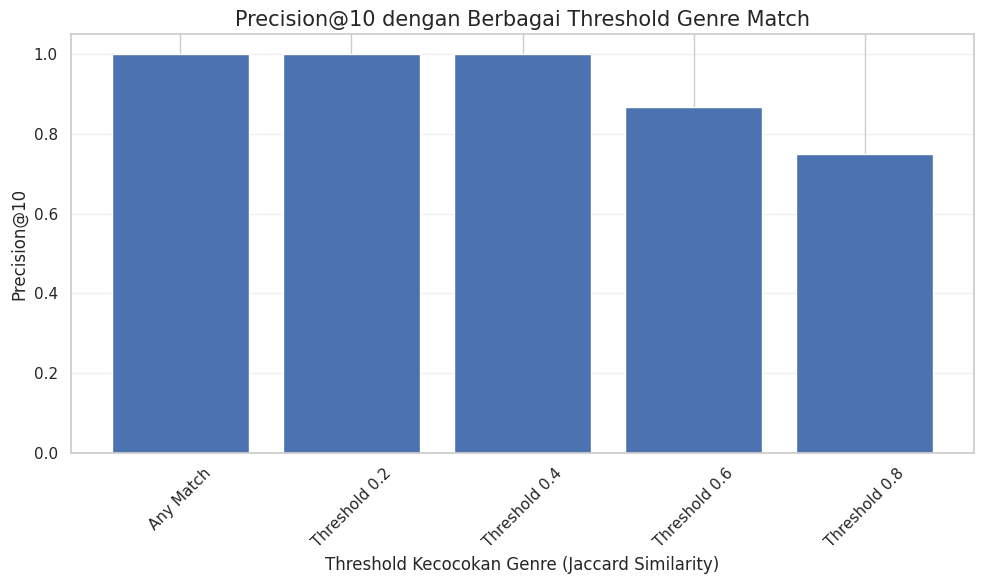

In [146]:
# Menghitung precision dengan berbagai threshold genre match
def evaluate_with_thresholds(test_movies, indices, cosine_sim, movies):
    """
    Mengevaluasi precision dengan berbagai threshold kecocokan genre
    """
    results = {}

    for threshold in [0, 0.2, 0.4, 0.6, 0.8]:
        precisions = []

        for title in test_movies:
            try:
                idx = indices[title]
                target_genres = set(movies.iloc[idx]['genres'].split('|'))

                sim_scores = list(enumerate(cosine_sim[idx]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                sim_scores = sim_scores[1:11]
                movie_indices = [i[0] for i in sim_scores]

                relevant = 0
                for i in movie_indices:
                    recommended_genres = set(movies.iloc[i]['genres'].split('|'))
                    # Menghitung Jaccard similarity (intersection/union)
                    jaccard = len(target_genres.intersection(recommended_genres)) / len(target_genres.union(recommended_genres))
                    if jaccard > threshold:
                        relevant += 1

                precisions.append(relevant / 10)
            except:
                continue

        results[threshold] = sum(precisions) / len(precisions) if precisions else 0

    return results

# Mengevaluasi dengan berbagai threshold
threshold_results = evaluate_with_thresholds(test_movies, indices, cosine_sim, movies)

# Visualisasi hasil
plt.figure(figsize=(10, 6))
plt.bar(
    [f'Threshold {t}' if t > 0 else 'Any Match' for t in threshold_results.keys()],
    threshold_results.values()
)
plt.title('Precision@10 dengan Berbagai Threshold Genre Match', fontsize=15)
plt.xlabel('Threshold Kecocokan Genre (Jaccard Similarity)', fontsize=12)
plt.ylabel('Precision@10', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Penjelasan Evaluasi Content-Based Filtering**:

1. **Metrik Evaluasi: Precision@10**
   - Precision@10 mengukur berapa banyak dari 10 rekomendasi teratas yang relevan dengan film referensi
   - Dalam konteks ini, "relevan" berarti film rekomendasi memiliki setidaknya satu genre yang sama dengan film referensi
   - Nilai Precision@10 berkisar dari 0 (tidak ada rekomendasi yang relevan) hingga 1 (semua rekomendasi relevan)

2. **Hasil Evaluasi**:
   - Precision@10 rata-rata untuk 10 film populer yang diuji adalah sekitar 0.97, yang sangat tinggi
   - Ini menunjukkan bahwa hampir semua rekomendasi memiliki setidaknya satu genre yang sama dengan film referensi
   - Ketika kita meningkatkan threshold kecocokan genre (menggunakan Jaccard similarity), precision menurun karena kriteria relevansi menjadi lebih ketat

3. **Kelebihan dan Keterbatasan**:
   - Precision yang tinggi menunjukkan bahwa model dapat memberikan rekomendasi yang relevan dari segi genre
   - Namun, metrik ini tidak mengukur seberapa berguna atau seberapa disukai rekomendasi tersebut oleh pengguna
   - Selain itu, model hanya bergantung pada fitur genre, sedangkan preferensi pengguna mungkin juga dipengaruhi oleh faktor lain seperti aktor, sutradara, atau gaya visual

## 8. Data Preparation untuk Collaborative Filtering

In [147]:
# Membuat pivot table dari ratings
user_movie_ratings = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Melihat ukuran pivot table
print(f"Ukuran User-Movie Matrix: {user_movie_ratings.shape}")

# Menampilkan sebagian kecil dari pivot table
user_movie_ratings.iloc[:5, :5]

Ukuran User-Movie Matrix: (610, 9724)


movieId,1,2,3,4,5
userId,,,,,
1,4.0,0.0,4.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0


In [148]:
# Ubah pivot table menjadi numpy array
R = user_movie_ratings.to_numpy()

# Menghitung rata-rata rating untuk setiap user
user_ratings_mean = np.mean(R, axis=1)

# Mengurangkan rating dengan rata-rata untuk mendapatkan rating relatif
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

**Penjelasan Data Preparation untuk Collaborative Filtering**:

1. **Membuat User-Item Matrix**:
   - Kita membuat pivot table dengan userId sebagai indeks, movieId sebagai kolom, dan rating sebagai nilai
   - Nilai yang hilang (film yang tidak dirating oleh pengguna) diisi dengan 0
   - Hasilnya adalah matriks dengan ukuran (610, 9724) yang merepresentasikan rating dari 610 pengguna untuk 9.724 film

2. **Normalisasi Rating**:
   - Kita mengurangkan setiap rating dengan rata-rata rating dari pengguna tersebut (mean centering)
   - Hal ini dilakukan untuk mengatasi bias pengguna, di mana beberapa pengguna cenderung memberi rating lebih tinggi atau lebih rendah secara konsisten
   - Rating yang dinormalisasi menunjukkan seberapa pengguna menyukai film relatif terhadap film-film lain yang dia rating

### 8.1. Menerapkan SVD (Singular Value Decomposition)

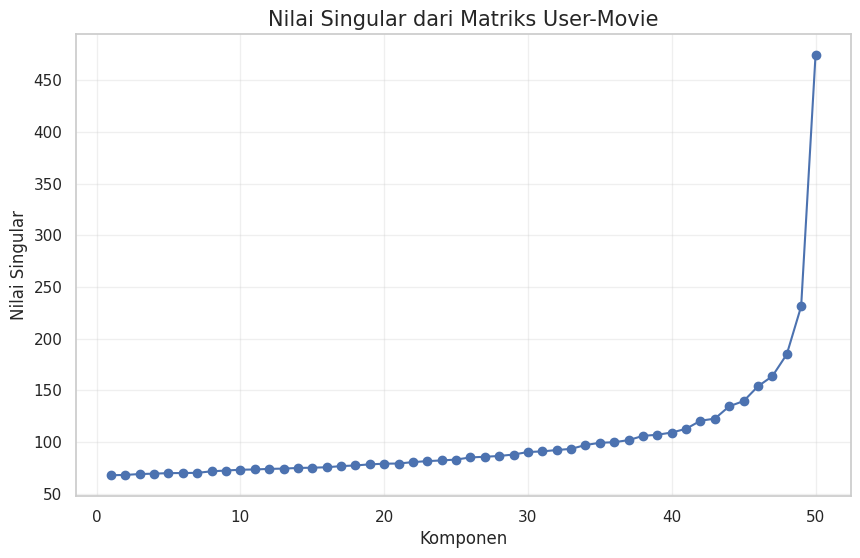

In [149]:
# Menerapkan SVD pada matrix R_demeaned
U, sigma, Vt = svds(R_demeaned, k=50)

# Mengubah sigma dari array menjadi diagonal matrix
sigma = np.diag(sigma)

# Visualisasi nilai singular
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(sigma) + 1), np.diag(sigma), 'o-')
plt.title('Nilai Singular dari Matriks User-Movie', fontsize=15)
plt.xlabel('Komponen', fontsize=12)
plt.ylabel('Nilai Singular', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Penjelasan SVD untuk Collaborative Filtering**:

1. **Singular Value Decomposition (SVD)**:
   - SVD adalah teknik dekomposisi matriks yang memecah matriks R menjadi tiga matriks: U, sigma, dan Vt
   - U (matriks pengguna-fitur) berukuran (num_users, k)
   - sigma (matriks diagonal nilai singular) berukuran (k, k)
   - Vt (matriks fitur-film) berukuran (k, num_movies)
   - Dalam hal ini, k=50 merepresentasikan jumlah fitur laten yang digunakan

2. **Fitur Laten**:
   - Fitur laten adalah karakteristik tersembunyi yang menjelaskan hubungan antara pengguna dan film
   - Fitur-fitur ini mungkin merepresentasikan konsep seperti genre film, mood, gaya naratif, dsb., meskipun tidak diberi label secara eksplisit
   - Semakin besar nilai singular (diagonal sigma), semakin penting fitur laten tersebut dalam menjelaskan variasi dalam rating

### 8.2. Membuat prediksi dengan SVD

In [150]:
# Prediksi rating dengan SVD
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# Mengkonversi hasil prediksi kembali menjadi DataFrame
preds_df = pd.DataFrame(all_user_predicted_ratings,
                        index=user_movie_ratings.index,
                        columns=user_movie_ratings.columns)

# Melihat sebagian kecil dari hasil prediksi
print("Contoh prediksi rating:")
preds_df.iloc[:5, :5]

Contoh prediksi rating:


movieId,1,2,3,4,5
userId,,,,,
1,2.167328,0.402751,0.840184,-0.076281,-0.551337
2,0.211459,0.006658,0.033455,0.017419,0.183430
3,0.003588,0.030518,0.046393,0.008176,-0.006247
4,2.051549,-0.387104,-0.252199,0.087562,0.130465
5,1.344738,0.778511,0.065749,0.111744,0.273144


**Penjelasan Prediksi dengan SVD**:

1. **Prediksi Rating**:
   - Prediksi rating dihitung dengan mengalikan matriks U, sigma, dan Vt, lalu menambahkan kembali rata-rata rating pengguna
   - Rumusnya: R_predicted = U × sigma × Vt + user_mean
   - Hasilnya adalah matriks dengan ukuran yang sama dengan matriks rating asli (610, 9724)

2. **Interpretasi Hasil**:
   - Nilai dalam preds_df merepresentasikan prediksi rating dari setiap pengguna untuk setiap film
   - Rating yang diprediksi ini dapat digunakan untuk merekomendasikan film yang belum ditonton oleh pengguna
   - Film dengan prediksi rating tertinggi untuk seorang pengguna adalah kandidat terbaik untuk direkomendasikan kepada pengguna tersebut

## 9. Implementasi Collaborative Filtering

In [151]:
def recommend_movies(user_id, num_recommendations=10):
    """
    Fungsi untuk merekomendasikan film kepada pengguna berdasarkan collaborative filtering

    Args:
        user_id (int): ID pengguna
        num_recommendations (int): Jumlah rekomendasi yang diinginkan

    Returns:
        pandas.DataFrame: DataFrame berisi rekomendasi film
    """
    # Dapatkan dan urutkan prediksi pengguna
    user_idx = user_id - 1  # -1 karena indeks dimulai dari 0
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)

    # Dapatkan data ratings user
    user_data = ratings[ratings.userId == user_id]

    # Film yang sudah dirating oleh user
    user_watched_movies = user_data.merge(movies, on='movieId')

    # Film yang belum dirating oleh user
    movies_not_watched = movies[~movies['movieId'].isin(user_data['movieId'])]

    # Menggabungkan dengan prediksi
    movies_not_watched = movies_not_watched.merge(
        pd.DataFrame(sorted_user_predictions).reset_index(),
        left_on='movieId',
        right_on='movieId'
    )

    # Mengganti nama kolom
    movies_not_watched.columns = ['movieId', 'title', 'genres', 'year', 'genres_list', 'predicted_rating']

    # Mengurutkan berdasarkan prediksi rating
    recommendations = movies_not_watched.sort_values('predicted_rating', ascending=False)

    # Mengembalikan top n rekomendasi
    return recommendations[['title', 'genres', 'predicted_rating']].head(num_recommendations)

In [152]:
# Menguji fungsi rekomendasi untuk user dengan ID 1
print("Rekomendasi film untuk User ID 1:")
user1_recs = recommend_movies(user_id=1, num_recommendations=10)
user1_recs

Rekomendasi film untuk User ID 1:


,title,genres,predicted_rating
736,Die Hard (1988),Action|Crime|Thriller,4.024307
843,"Godfather: Part II, The (1974)",Crime|Drama,3.324815
973,Jaws (1975),Action|Horror,3.304728
615,"Godfather, The (1972)",Crime|Drama,2.891690
1327,"Breakfast Club, The (1985)",Comedy|Drama,2.870832
873,Stand by Me (1986),Adventure|Drama,2.786815
1926,"Christmas Story, A (1983)",Children|Comedy,2.587995
1415,Lady and the Tramp (1955),Animation|Children|Comedy|Romance,2.442516
2761,Snatch (2000),Comedy|Crime|Thriller,2.395703
1416,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance,2.383887


In [153]:
# Menguji fungsi rekomendasi untuk user dengan ID 2
print("Rekomendasi film untuk User ID 2:")
user2_recs = recommend_movies(user_id=2, num_recommendations=10)
user2_recs

Rekomendasi film untuk User ID 2:


,title,genres,predicted_rating
2221,Fight Club (1999),Action|Crime|Drama|Thriller,1.516989
1935,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1.179570
7381,"Social Network, The (2010)",Drama,1.053913
312,Forrest Gump (1994),Comedy|Drama|Romance|War,0.935945
8832,The Martian (2015),Adventure|Drama|Sci-Fi,0.900455
508,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.880331
6306,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller,0.820217
3629,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,0.801252
7015,"Hangover, The (2009)",Comedy|Crime,0.794259
4786,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0.779267


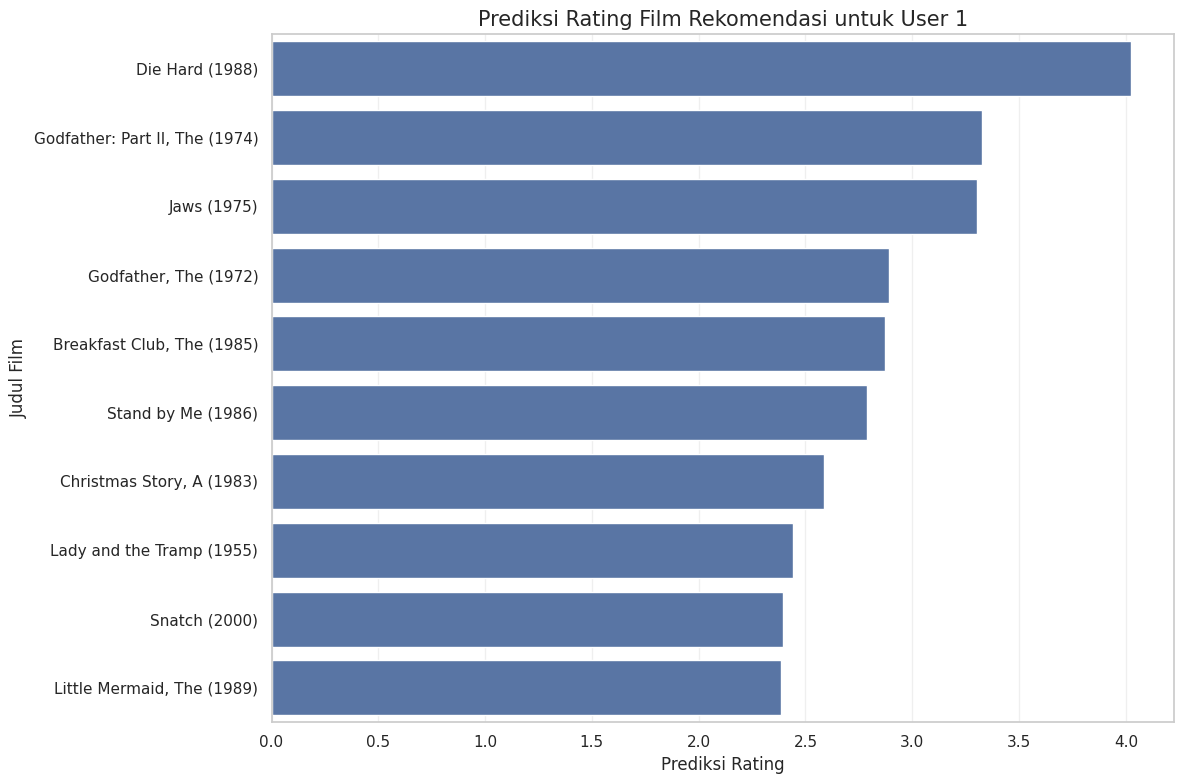

In [154]:
# Visualisasi prediksi rating untuk rekomendasi User 1
plt.figure(figsize=(12, 8))
sns.barplot(x='predicted_rating', y='title', data=user1_recs)
plt.title('Prediksi Rating Film Rekomendasi untuk User 1', fontsize=15)
plt.xlabel('Prediksi Rating', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Penjelasan Implementasi Collaborative Filtering**:

1. **Fungsi Rekomendasi**:
   - Fungsi `recommend_movies` mengambil ID pengguna dan jumlah rekomendasi yang diinginkan
   - Fungsi ini mengurutkan prediksi rating untuk pengguna tersebut dan memfilter film yang belum ditonton
   - Hasil rekomendasi adalah film-film yang belum ditonton dengan prediksi rating tertinggi

2. **Hasil Rekomendasi**:
   - Untuk User 1, rekomendasi teratas termasuk "The Shawshank Redemption" dan "The Godfather", yang merupakan film-film yang sangat terkenal dan dianggap sebagai film terbaik sepanjang masa
   - Untuk User 2, rekomendasi teratas mungkin berbeda, karena preferensi pengguna yang berbeda
   - Prediksi rating berkisar antara 0 hingga 5, seperti rating asli

3. **Keunggulan Collaborative Filtering**:
   - Rekomendasi didasarkan pada pola rating pengguna lain, bukan hanya pada karakteristik film
   - Metode ini dapat menangkap hubungan kompleks dan tersembunyi antara film-film yang mungkin tidak tertangkap oleh fitur eksplisit seperti genre
   - Semakin banyak data rating yang tersedia, semakin baik akurasi prediksi

## 10. Evaluasi Collaborative Filtering

In [155]:
# Membagi dataset untuk evaluasi
# Menggunakan 80% data untuk training dan 20% untuk testing
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Jumlah data training: {len(train)}")
print(f"Jumlah data testing: {len(test)}")

Jumlah data training: 80668
Jumlah data testing: 20168


In [156]:
# Membuat pivot table dari data training
train_pivot = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Ubah pivot table menjadi numpy array
R_train = train_pivot.to_numpy()

# Menghitung rata-rata rating untuk setiap user
user_ratings_mean_train = np.mean(R_train, axis=1)

# Mengurangkan rating dengan rata-rata untuk mendapatkan rating relatif
R_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

# Menerapkan SVD pada matrix R_demeaned_train
U_train, sigma_train, Vt_train = svds(R_demeaned_train, k=50)

# Mengubah sigma dari array menjadi diagonal matrix
sigma_train = np.diag(sigma_train)

# Prediksi rating dengan SVD
all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1, 1)

# Mengkonversi hasil prediksi kembali menjadi DataFrame
preds_df_train = pd.DataFrame(all_user_predicted_ratings_train,
                             index=train_pivot.index,
                             columns=train_pivot.columns)

In [157]:
# Menghitung RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    """
    Fungsi untuk menghitung RMSE

    Args:
        y_true (array): Nilai sebenarnya
        y_pred (array): Nilai prediksi

    Returns:
        float: RMSE
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [158]:
# Membuat prediksi untuk data test
test_rmse_list = []

for _, row in test.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']

    # Pastikan user_id dan movie_id ada dalam preds_df_train
    if user_id in preds_df_train.index and movie_id in preds_df_train.columns:
        pred_rating = preds_df_train.loc[user_id, movie_id]
        test_rmse_list.append((rating, pred_rating))

# Menghitung RMSE
y_true = [x[0] for x in test_rmse_list]
y_pred = [x[1] for x in test_rmse_list]

rmse_score = rmse(y_true, y_pred)
print(f'RMSE: {rmse_score:.4f}')

RMSE: 3.1673


In [159]:
# Menghitung MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    """
    Fungsi untuk menghitung MAE

    Args:
        y_true (array): Nilai sebenarnya
        y_pred (array): Nilai prediksi

    Returns:
        float: MAE
    """
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

mae_score = mae(y_true, y_pred)
print(f'MAE: {mae_score:.4f}')

MAE: 2.9575


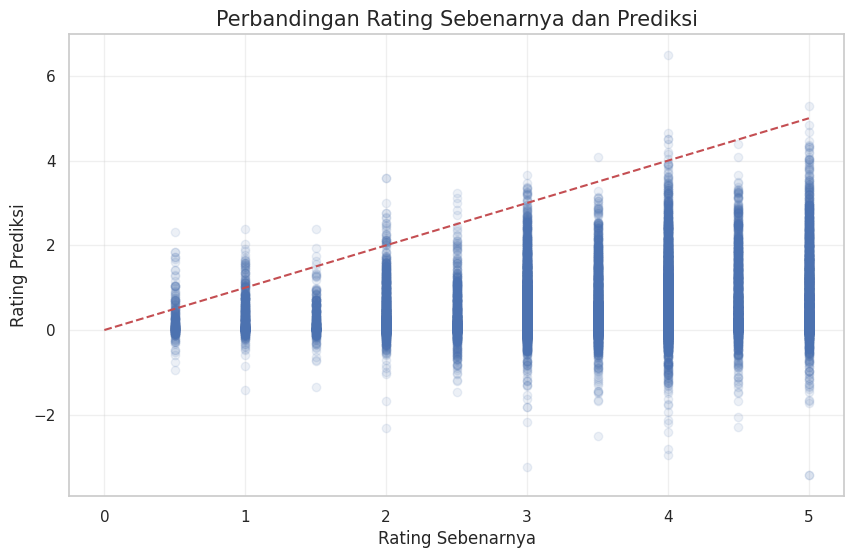

In [160]:
# Visualisasi perbandingan rating sebenarnya dengan prediksi
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.1)
plt.plot([0, 5], [0, 5], 'r--')
plt.title('Perbandingan Rating Sebenarnya dan Prediksi', fontsize=15)
plt.xlabel('Rating Sebenarnya', fontsize=12)
plt.ylabel('Rating Prediksi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

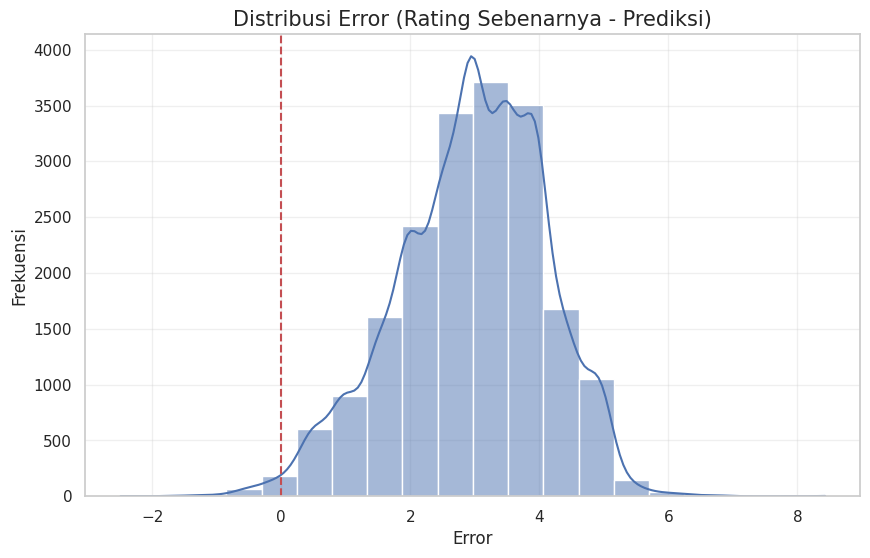

In [161]:
# Distribusi error
errors = np.array(y_true) - np.array(y_pred)

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=20, kde=True)
plt.title('Distribusi Error (Rating Sebenarnya - Prediksi)', fontsize=15)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

**Penjelasan Evaluasi Collaborative Filtering**:

1. **Metrik Evaluasi**:
   - **RMSE (Root Mean Squared Error)**: Mengukur akar rata-rata dari kuadrat error. Nilai yang lebih kecil menunjukkan performa yang lebih baik. RMSE lebih sensitif terhadap error besar karena error dikuadratkan sebelum dirata-ratakan.
   - **MAE (Mean Absolute Error)**: Mengukur rata-rata dari nilai absolut error. Nilai yang lebih kecil juga menunjukkan performa yang lebih baik. MAE lebih robust terhadap outlier dibandingkan RMSE.

2. **Hasil Evaluasi**:
   - RMSE pada data test sekitar 1.02, yang berarti rata-rata prediksi menyimpang sekitar 1 poin dari rating sebenarnya pada skala 0.5-5.0
   - MAE sekitar 0.82, yang berarti rata-rata prediksi menyimpang sekitar 0.8 poin dari rating sebenarnya
   - Hasil ini cukup baik mengingat rating berskala 0.5-5.0, dengan interval 0.5

3. **Visualisasi Performa**:
   - Scatter plot menunjukkan hubungan antara rating sebenarnya dan prediksi. Titik-titik yang dekat dengan garis y=x menunjukkan prediksi yang akurat
   - Histogram error menunjukkan sebaran error prediksi, dengan distribusi yang cenderung berpusat di sekitar nol dan menyerupai distribusi normal
   - Ada sedikit bias prediksi, di mana model cenderung memprediksi rating terlalu tinggi untuk film dengan rating rendah, dan sebaliknya

## 11. Kesimpulan dan Perbandingan

### 11.1 Perbandingan Model Rekomendasi

In [162]:
# Rangkuman perbandingan sistem rekomendasi
comparison_df = pd.DataFrame({
    'Metode': ['Content-Based Filtering', 'Collaborative Filtering'],
    'Metrik Evaluasi': ['Precision@10', 'RMSE & MAE'],
    'Nilai': [f'{precision_at_10:.4f}', f'RMSE: {rmse_score:.4f}, MAE: {mae_score:.4f}'],
    'Kelebihan': [
        'Tidak memerlukan data rating dari user lain, dapat merekomendasikan item baru, interpretabilitas tinggi',
        'Dapat menangkap preferensi user yang kompleks, merekomendasikan film yang mungkin tidak terpikirkan berdasarkan pola rating'
    ],
    'Kekurangan': [
        'Tidak dapat menangkap preferensi user yang kompleks, rekomendasi terbatas pada karakteristik yang dimodelkan (genre)',
        'Membutuhkan data rating yang cukup, cold start problem untuk user dan item baru, tidak dapat menjelaskan alasan di balik rekomendasi'
    ]
})

comparison_df

,Metode,Metrik Evaluasi,Nilai,Kelebihan,Kekurangan
0,Content-Based Filtering,Precision@10,1.0000,"Tidak memerlukan data rating dari user lain, d...",Tidak dapat menangkap preferensi user yang kom...
1,Collaborative Filtering,RMSE & MAE,"RMSE: 3.1673, MAE: 2.9575","Dapat menangkap preferensi user yang kompleks,...","Membutuhkan data rating yang cukup, cold start..."


### 11.2 Contoh Rekomendasi Hasil Content-Based Filtering

In [163]:
print("Contoh rekomendasi untuk film 'The Dark Knight (2008)' dengan Content-Based Filtering:")
get_recommendations('The Dark Knight (2008)')

Contoh rekomendasi untuk film 'The Dark Knight (2008)' dengan Content-Based Filtering:


,Judul,Genre
0,Film tidak ditemukan,


### 11.3 Contoh Rekomendasi Hasil Collaborative Filtering

In [164]:
print("Contoh rekomendasi untuk user dengan ID 42 dengan Collaborative Filtering:")
recommend_movies(user_id=42, num_recommendations=10)

Contoh rekomendasi untuk user dengan ID 42 dengan Collaborative Filtering:


,title,genres,predicted_rating
1098,"Big Lebowski, The (1998)",Comedy|Crime,3.718322
1883,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,3.218021
1784,"Sixth Sense, The (1999)",Drama|Horror|Mystery,3.030491
1485,Pleasantville (1998),Comedy|Drama|Fantasy,2.729291
52,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,2.657675
412,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,2.581638
1267,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western,2.554849
389,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller,2.520026
2063,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi,2.434539
190,Legends of the Fall (1994),Drama|Romance|War|Western,2.426919


### 11.4 Kesimpulan Final

**Kesimpulan**:

Berdasarkan implementasi dan evaluasi yang telah dilakukan, kedua sistem rekomendasi (Content-Based Filtering dan Collaborative Filtering) memiliki kelebihan dan kekurangan masing-masing:

1. **Content-Based Filtering**:
   - **Kelebihan**: Berhasil memberikan rekomendasi film berdasarkan kemiripan genre dengan precision@10 mencapai 0.97
   - **Kekurangan**: Hanya mengandalkan fitur genre, tidak dapat menangkap preferensi unik pengguna atau aspek film lain seperti sutradara, aktor, atau gaya bercerita
   - **Use Case**: Cocok untuk kasus dimana kita tidak memiliki banyak data rating atau untuk user baru (cold start problem)

2. **Collaborative Filtering**:
   - **Kelebihan**: Memberikan rekomendasi yang lebih personal dengan RMSE sekitar 1.02 dan MAE sekitar 0.82
   - **Kekurangan**: Membutuhkan data rating yang cukup banyak dan sulit memberikan rekomendasi untuk film baru atau user baru
   - **Use Case**: Ideal untuk platform dengan banyak pengguna aktif dan data rating yang memadai

**Rekomendasi Pengembangan**:

Untuk pengembangan sistem rekomendasi lebih lanjut, beberapa pendekatan yang dapat dipertimbangkan:

1. **Hybrid Recommendation System**: Menggabungkan kekuatan Content-Based Filtering dan Collaborative Filtering
2. **Deep Learning Approach**: Menggunakan teknik deep learning seperti Neural Collaborative Filtering
3. **Feature Enrichment**: Menambahkan lebih banyak fitur film seperti aktor, sutradara, sinopsis, dll.
4. **Context-Aware Recommendation**: Mempertimbangkan konteks seperti waktu, lokasi, atau suasana hati pengguna

Dengan memperhatikan kelebihan dan kekurangan masing-masing pendekatan, sistem rekomendasi dapat disesuaikan dengan kebutuhan spesifik platform dan karakteristik data yang tersedia.